<a href="https://colab.research.google.com/github/adityasahusomu/Youtube_Comment_Analyzer/blob/main/Baseline_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import mlflow
mlflow.set_tracking_uri('http://ec2-3-15-32-230.us-east-2.compute.amazonaws.com:5000')



In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [2]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.2/738.2 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/7

In [5]:
df.isnull().sum()

,0
clean_comment,100
category,0


In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

,0
clean_comment,0
category,0


In [8]:
df.duplicated().sum()

np.int64(350)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df = df[~(df['clean_comment'].str.strip() == '')]

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [12]:
def preprocess_comment(comment):
    comment = comment.lower()     # lower case conversion

    comment = comment.strip() # for trailing and leading space
    comment = re.sub(r'\n', ' ', comment)     # for \n chars
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)    #non-alphanumeric chars
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join(word for word in comment.split() if word not in stop_words)

    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [13]:
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [14]:
from bs4 import BeautifulSoup
def html_tags_rem(comment):
  return BeautifulSoup(comment, "html.parser").get_text()

df['clean_comment'] = df['clean_comment'].apply(html_tags_rem)
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [15]:
df.to_csv('cleaned_reddit_dataset.csv', index = False)

In [17]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Step 1: Vectorize the comments using BOW
vectorizer = CountVectorizer(max_features=10000)

In [19]:
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category']

In [20]:
X.shape             #no of comments * no of max words

(36793, 10000)

In [21]:
# step 2: setting up mlflow traicking server
mlflow.set_tracking_uri('http://ec2-3-15-32-230.us-east-2.compute.amazonaws.com:5000')

In [22]:
# setting or creating an experiment
mlflow.set_experiment('Exp-1-RF_baseline')

2025/10/15 10:58:57 INFO mlflow.tracking.fluent: Experiment with name 'Exp-1-RF_baseline' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://project1-mlflow-bucket/976441530164161912', creation_time=1760525937643, experiment_id='976441530164161912', last_update_time=1760525937643, lifecycle_stage='active', name='Exp-1-RF_baseline', tags={}>

2025/10/15 11:15:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/15 11:16:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_Baseline_TrainTestSplit at: http://ec2-3-15-32-230.us-east-2.compute.amazonaws.com:5000/#/experiments/976441530164161912/runs/83b60f100c884a929dbec3efde995fbf
🧪 View experiment at: http://ec2-3-15-32-230.us-east-2.compute.amazonaws.com:5000/#/experiments/976441530164161912
Accuracy: 0.65810572088599


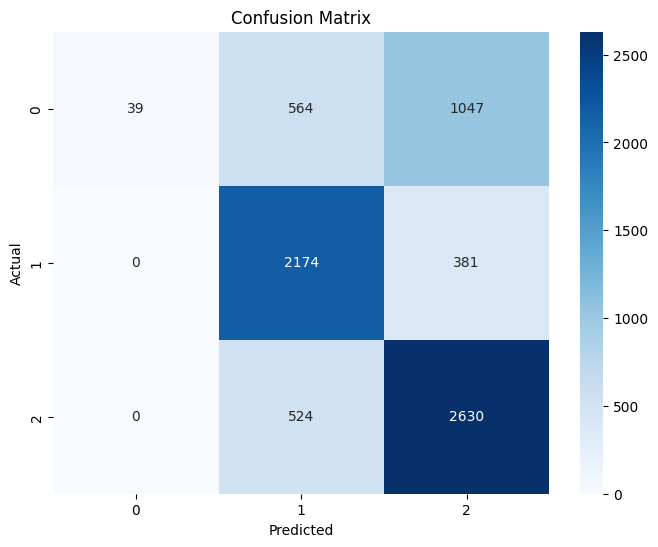

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

with mlflow.start_run() as run:
    # Adding tags
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Adding description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 150
    max_depth = 20

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Saving and logging the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("/content/confusion_matrix.png")

    # Logging the Random Forest model


    mlflow.sklearn.log_model(model,
                             artifact_path="random_forest_model")

    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("/content/dataset.csv")

print(f"Accuracy: {accuracy}")

In [24]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.5 MB/s eta 0:00:00


In [25]:
!pip install awscli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9.1
    Uninstalling rsa-4.9.1:
      Successfully uninstalled rsa-4.9.1
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.


In [29]:
import os, getpass

os.environ["AWS_ACCESS_KEY_ID"] = getpass.getpass("Enter AWS Access Key ID: ")
os.environ["AWS_SECRET_ACCESS_KEY"] = getpass.getpass("Enter AWS Secret Access Key: ")
os.environ["AWS_DEFAULT_REGION"] = "us-east-1"

Enter AWS Access Key ID: ··········
Enter AWS Secret Access Key: ··········


In [30]:
import boto3
s3 = boto3.client('s3')
print(s3.list_buckets())

{'ResponseMetadata': {'RequestId': 'TTAM5SQBY2PDQR43', 'HostId': '4LS5BXq+iGQ3X8eq3+sZ/VH+i2UNl1N6fZXHbQ0Je8GJPAiAbaYIKvjM5qHxaYAYmbXDEAflm68=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': '4LS5BXq+iGQ3X8eq3+sZ/VH+i2UNl1N6fZXHbQ0Je8GJPAiAbaYIKvjM5qHxaYAYmbXDEAflm68=', 'x-amz-request-id': 'TTAM5SQBY2PDQR43', 'date': 'Wed, 15 Oct 2025 11:48:53 GMT', 'content-type': 'application/xml', 'transfer-encoding': 'chunked', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'Buckets': [{'Name': 'project1-mlflow-bucket', 'CreationDate': datetime.datetime(2025, 10, 12, 12, 4, 13, tzinfo=tzlocal())}], 'Owner': {'DisplayName': 'adityasahusomu02', 'ID': '866466d6c4d8a9893e39cdce3c468d75133f23de2c907deeda4f1a78a7ca565b'}}
